In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy
import random
import cmath
#import pylops # might not need
import math
import pyproximal

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable, deserialize_keras_object
from tensorflow.test import compute_gradient
from tensorflow.compat.v1 import assign_sub

from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize

import autosetup 
from backpropagation import CBP, CBP_decoder
from complex_optimizer import Complex_SGD, adaptive_stepsize

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Some nice tensorflow links
https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#putting_it_all_together_an_end-to-end_example 
https://www.tensorflow.org/guide/keras/functional_api
https://www.tensorflow.org/api_docs/python/tf/keras/Layer#used-in-the-notebooks
https://www.tensorflow.org/api_docs/python/tf/keras/Layer#call

## Autoencoder

### Dataset

In [3]:
# code from: https://www.tensorflow.org/tutorials/generative/autoencoder

In [34]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255. #normalize the data
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# make a smaller training set
x_train_temp = x_train[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [10,10])
x_train_small = x_train_temp[:,:,:,0]

x_test_temp = x_test[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [10,10])
x_test_small = x_test_temp[:,:,:,0]

#x_train_small = tf.image.resize(x_train, [10, 10])
#x_test_small = tf.image.resize(x_test, [10, 10])

print(x_train_small.shape)
print(x_test_small.shape)

# make a complex (smaller) training set
x_train_cx_small = tf.complex(np.ones((x_train_small.shape)).astype('float32'), x_train_small)
x_test_cx_small = tf.complex(np.ones((x_test_small.shape)).astype('float32'), x_test_small)

# make the training set smaller for testing code
x_train_cx_reduced = x_train_cx_small[0:10000, :, :]

print(x_train_cx_small.shape)
print(type(x_train_cx_small))

print(x_train_cx_reduced.shape[0])

print(x_test_cx_small[0])


(60000, 28, 28)
(10000, 28, 28)
(60000, 10, 10)
(10000, 10, 10)
(60000, 10, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>
10000
tf.Tensor(
[[1.+0.j         1.+0.j         1.+0.j         1.+0.j
  1.+0.j         1.+0.j         1.+0.j         1.+0.j
  1.+0.j         1.+0.j        ]
 [1.+0.j         1.+0.j         1.+0.j         1.+0.j
  1.+0.j         1.+0.j         1.+0.j         1.+0.j
  1.+0.j         1.+0.j        ]
 [1.+0.j         1.+0.j         1.+0.2637255j  1.+0.24254899j
  1.+0.j         1.+0.j         1.+0.j         1.+0.j
  1.+0.j         1.+0.j        ]
 [1.+0.j         1.+0.j         1.+0.24843131j 1.+0.35329404j
  1.+0.7608235j  1.+0.7760783j  1.+0.68403924j 1.+0.75254905j
  1.+0.j         1.+0.j        ]
 [1.+0.j         1.+0.j         1.+0.j         1.+0.j
  1.+0.j         1.+0.j         1.+0.6838421j  1.+0.15509808j
  1.+0.j         1.+0.j        ]
 [1.+0.j         1.+0.j         1.+0.j         1.+0.j
  1.+0.j         1.+0.j         1.+0.8299611j  1.+0.j
  1.

(183, 64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(183, 64)


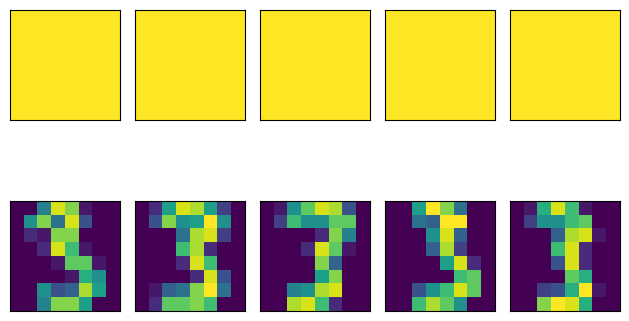

In [39]:
# load MNIST dataset from ptygenography instead
X_pty = np.load('MNIST_64_only3.npy')
n = X_pty.shape[1]
nx = int(np.sqrt(n))
print(X_pty.shape)

X_tf = tf.convert_to_tensor(X_pty, dtype=tf.complex64)
print(type(X_tf))
print(X_tf.shape)

# show the data
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = X_pty[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

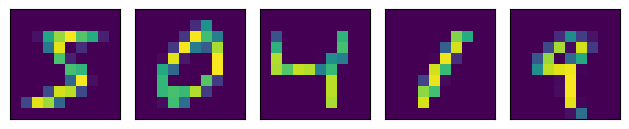

In [3]:
# representation training dataset (real case)
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    x = x_train_small[i]
    ax[i].imshow(np.real(x).reshape((10,10)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

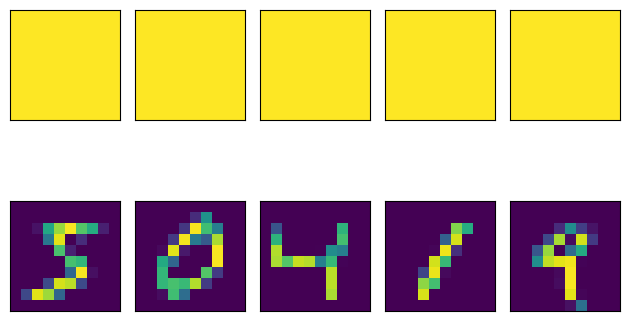

In [4]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = x_train_cx_small[i]
    ax[0,i].imshow(np.real(x).reshape((10,10)),clim=[0,1], cmap= 'viridis')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((10,10)),clim=[0,1], cmap='viridis')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()


### Training loop

In [40]:
# wrapper for training
@tf.function
def train_step(x, alpha, encoder, decoder, optimizer):
    y = decoder(encoder(x))
    loss_value = autosetup.loss_MSE(y, x)
    grads_and_vars = CBP(x, y, encoder, decoder, autosetup.dLossdaL, autosetup.Jac_modrelu)
    new_alpha = adaptive_stepsize(x, y, alpha, encoder, decoder, autosetup.loss_MSE, grads_and_vars)
    _ = optimizer.apply_gradients(grads_and_vars, alpha = alpha)
    return loss_value, new_alpha

In [56]:
# parameters (might move somewhere else)
EPOCHS = 1000
dataset = X_tf[:173] # keep last 10 for testing
dataset_size = dataset.shape[0]
reshape_dataset = tf.reshape(dataset, (dataset_size,-1))
sample_shape = reshape_dataset.shape[-1] # data dimension
latent_dim = 30 # reduction of data 

print("dataset_size", dataset_size)
print("sample dimension", sample_shape)
#train_dataset = tf.data.Dataset.from_tensor_slices(reshape_dataset).batch(1)

dataset_size 173
sample dimension 64


In [57]:
# ref: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

train_dataset = (
    tf.data.Dataset.from_tensor_slices(reshape_dataset)
    .shuffle(dataset_size, reshuffle_each_iteration=True) # reshuffle the entire dataset
    .batch(1)
)

encoder = autosetup.ComplexEncoder([45, latent_dim])
decoder = autosetup.ComplexDecoder([45, sample_shape])

# initialize layers: on first call their shape is set based on the shapes of the first data
dummy = tf.zeros((1, sample_shape), dtype=tf.complex64)
_ = decoder(encoder(dummy))

print(type(train_dataset))

optimizer = Complex_SGD()
alpha = 1e-4 # initial value

for epoch in range(EPOCHS):
    print(f"\nStart of epoch {epoch+1}")
    start_time = time.time()

    count = 0
    epoch_loss = 0.0
    for x in train_dataset:
        loss, alpha = train_step(x, alpha, encoder, decoder, optimizer)

        count += 1 # this is a bit ugly
        epoch_loss += loss.numpy()

        if count % (dataset_size/10) == 0:
            print(
                "Training loss (for one sample) at sample %d: %.4f"
                % (count, float(loss))
            )

    avg_loss = epoch_loss/(dataset_size)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.5f} | Max grad norm: ") # {max_grad_norm:.2f} TODO
    print("Time taken: %.2fs" % (time.time() - start_time))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>

Start of epoch 1
Epoch 1 | Loss: 50.43673 | Max grad norm: 
Time taken: 3.16s

Start of epoch 2
Epoch 2 | Loss: 14.99907 | Max grad norm: 
Time taken: 0.48s

Start of epoch 3
Epoch 3 | Loss: 10.62158 | Max grad norm: 
Time taken: 0.50s

Start of epoch 4
Epoch 4 | Loss: 8.81966 | Max grad norm: 
Time taken: 0.61s

Start of epoch 5
Epoch 5 | Loss: 7.61742 | Max grad norm: 
Time taken: 0.55s

Start of epoch 6
Epoch 6 | Loss: 6.85017 | Max grad norm: 
Time taken: 0.50s

Start of epoch 7
Epoch 7 | Loss: 6.28445 | Max grad norm: 
Time taken: 0.53s

Start of epoch 8
Epoch 8 | Loss: 5.71482 | Max grad norm: 
Time taken: 0.54s

Start of epoch 9
Epoch 9 | Loss: 5.32407 | Max grad norm: 
Time taken: 0.52s

Start of epoch 10
Epoch 10 | Loss: 5.07127 | Max grad norm: 
Time taken: 0.62s

Start of epoch 11
Epoch 11 | Loss: 4.77699 | Max grad norm: 
Time taken: 0.57s

Start of epoch 12
Epoch 12 | Loss: 4.50939 | Max grad norm: 
Time taken: 0

In [58]:
## save the encoder weights (not needed for least squares but helpful in generating examples)
wrap_encoder = autosetup.EncoderSave(encoder)
_ = wrap_encoder(tf.zeros((1, sample_shape), dtype = tf.complex64))

wrap_encoder.save_weights("encoder_1000epochs_Xpty_k30.weights.h5")

In [59]:
## save the decoder weights
wrap_decoder = autosetup.DecoderSave(decoder)
_ = wrap_decoder(tf.zeros((1, latent_dim), dtype = tf.complex64))

wrap_decoder.save_weights("decoder_1000epochs_Xpty_k30_epochs1000.weights.h5")

In [ ]:
## load the encoder weights
encoder_from_load = autosetup.ComplexEncoder([50, latent_dim])
encoder_model_from_load = autosetup.EncoderSave(encoder_from_load)

## load the decoder weights
decoder_from_load = autosetup.ComplexDecoder([50, sample_shape])
model_from_load = autosetup.DecoderSave(decoder_from_load)

# build
dummy_enc = tf.zeros((1, sample_shape), dtype = tf.complex64)
_ = encoder_from_load(dummy_enc)
_ = encoder_model_from_load(dummy_enc)

dummy_dec = tf.zeros((1, latent_dim), dtype = tf.complex64)
_ = decoder_from_load(dummy_dec)
_ = model_from_load(tf.zeros((1, latent_dim), dtype = tf.complex64))

# load
#model_from_load.load_weights("saved_decoder_test.weights.h5")
model_from_load.load_weights("decoder_8epochs_x_cx_small.weights.h5")
#encoder_model_from_load.load_weights("encoder_8epochs_x_cx_small.weights.h5")

In [ ]:
## test if it does the same
x_testing = tf.reshape(x_train_cx_small[0], [1,-1])
print(x_testing.shape)
print(type(x_testing))
y = encoder(x_testing)

# if zeros are returned, test succesfull
#print(decoder(y) - model_from_load.decoder(y))

(1, 100)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[1.0560035 -7.74386898e-02j 1.0573239 +8.20555985e-02j
  1.1151439 -9.14341062e-02j 1.0566394 -3.52024026e-02j
  0.93093467-7.01772124e-02j 0.98010314-1.08131403e-02j
  1.0116947 -6.06522523e-02j 1.0721003 +2.21436489e-02j
  0.9977986 +7.54325837e-02j 1.1252183 -9.12407115e-02j
  0.98584217+7.65499771e-02j 1.1194189 -3.10081970e-02j
  1.0479074 +8.06405470e-02j 1.0364313 -1.06292199e-02j
  0.9330173 +1.00438990e-01j 1.053675  +2.20988348e-01j
  1.0738726 +2.39383459e-01j 1.0857968 +4.43139449e-02j
  1.03635   -7.87219480e-02j 0.9503862 -4.71685864e-02j
  0.9079056 -1.49019165e-02j 0.8564091 -3.92761752e-02j
  0.9362015 +5.44368252e-02j 0.9575463 +1.76161274e-01j
  1.0529252 +5.25073826e-01j 1.0500501 +6.51388526e-01j
  1.0366496 +5.24619102e-01j 1.1171299 +3.76128852e-01j
  0.96216846+6.17846064e-02j 1.0660409 +8.73341635e-02j
  1.0847453 -5.12152584e-03j 1.0241363 +4.79821227e-02j
  0.9760021 +1.58020541e-01j 1

In [6]:
## run if decoder should be loaded from save
decoder = model_from_load.decoder

#### Extracting and wrapping autoencoder function

(1, 64)
(1, 8, 8)
(1, 64)
tf.Tensor(
[[ 0.76033205+0.499869j    0.03125612-0.07013683j -0.80597395-0.85858244j
  -0.04072828+0.08318315j -0.44001102+0.2534781j  -0.        +0.j
  -0.5962155 +0.56593823j  0.39948237-0.8773457j   0.        +0.j
  -0.44541728-0.4327705j  -0.04914183+0.01028979j -0.34738308+0.7593429j
  -0.2841268 +0.5362347j   0.15344521+0.15696934j  0.11140734-1.9491427j
   0.24419409+0.77297854j -0.8544387 -0.06609839j  0.09462023+0.05154117j
   0.01554566+0.03732468j -0.20739411+0.01633058j -0.09366388+0.10109431j
  -0.11532701-0.01703579j -0.        +0.j         -0.86286026-0.98363626j
   0.8854239 +1.2958457j   0.95377666-0.44559228j  0.18710764-0.70623183j
  -1.4887398 -2.5469306j   0.49146828-0.06205234j -0.1154036 +0.15555811j]], shape=(1, 30), dtype=complex64)


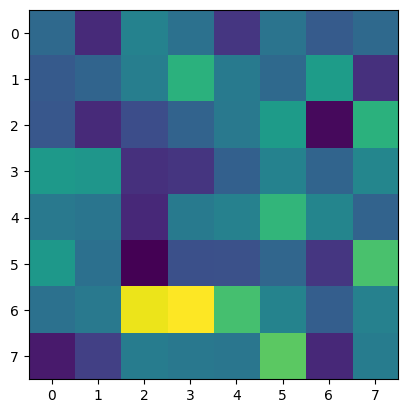

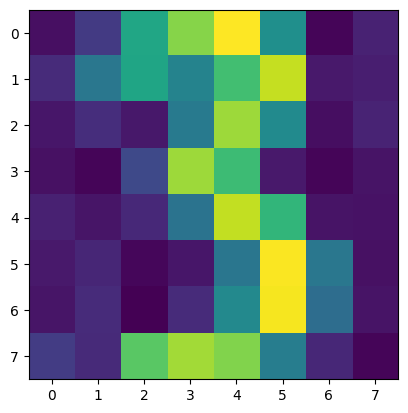

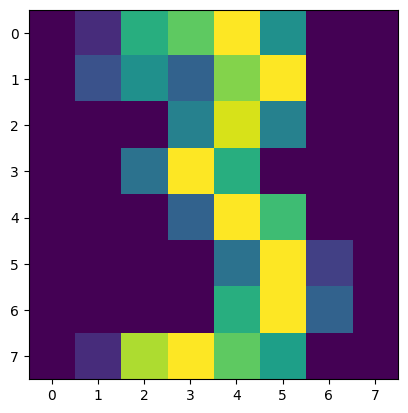

In [111]:
# random input looks like this
z_random = np.random.normal(size=(1,30))
test_z = decoder(z_random) #test_z is a tf 
print(test_z.shape)

show_z = tf.reshape(test_z, (1,8,8))
print(show_z.shape)

im_z = tf.math.imag(show_z)

plt.figure()
plt.imshow(im_z[0])

# an encoded digit looks like this
x_testing = tf.reshape(X_tf[-1], [1,-1])
print(x_testing.shape)
print(y)
y = encoder(x_testing)

x_recon = decoder(y)
im_x = tf.math.imag(tf.reshape(x_recon, (1,nx,nx)))

plt.figure()
plt.imshow(im_x[0])

plt.figure()
plt.imshow(tf.math.imag(tf.reshape(x_testing, (1,nx,nx)))[0])

In [9]:
# compute function generative map
def make_tensor_shape(z):
    #z = z.reshape((1,-1))
    tensor_z = tf.convert_to_tensor(z, dtype=tf.complex64)
    return tf.reshape(tensor_z,[1,-1])

def make_tensor(z):
    return tf.convert_to_tensor(z, dtype=tf.complex64)

# wrapper for decoder to numpy function
def decoderfunc_1D(z, decoder):
    '''
    Converts the autoencoder.decoder function into a generative embedding function

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))    

    output:
        decoderfunc_1D: function that maps z to numpy array of lenght dim^2 (flattened original image). flatten() ensures shape (n,) and not (1,n)
    '''
    return decoder(tf.reshape(make_tensor(z), [1,-1])).numpy().flatten()

# wrapper for Jacobian computation to numpy function
def jac_decoder_1D(z, decoder):
    '''
    Converts the CBP_decoder computation into a numpy function, outputting the R-derivative of the decoder in z as a numpy array
    NOTE: activation function is hardcoded at this point

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))
    '''
    dG_dz, _ = CBP_decoder(tf.reshape(make_tensor(z), [1,-1]), decoder, autosetup.Jac_modrelu)
    return dG_dz.numpy()

### Integrate with least squares signal optimization

In [ ]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)

    print("Dx norm", np.linalg.norm(Dx @ np.ones_like(zc)))
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    #print("Dy", Dy.shape)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

    print("val", val)
    #print("gradc", gradc)
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # print("xtrue", xtrue.shape)
    # print("yobs", yobs.shape)
    print("k", k)
    print("m", m)

    # inference
    #np.concatenate([np.ones(k), 0.5*np.ones(k)])
    fake_z0_tf = encoder(make_tensor_shape(xtrue))
    fake_z0_cx = fake_z0_tf.numpy().flatten()
    fake_z0 = np.concatenate([np.real(fake_z0_cx), np.imag(fake_z0_cx)])

    result = minimize(objective, x0=fake_z0, args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True, options={
        'maxiter': 10000,      # total outer iterations
        'maxls': 40,          # line search steps per iteration
        'ftol' : 1e-14,
        'gtol': 1e-14,         # gradient tolerance
        'disp': True          # print optimization log
    })
    
    # result = minimize(objective, np.concatenate([np.ones(k), 0.5*np.ones(k)]), args=(yobs, A, G, w, lmbda), method='Powell', jac=True, options={
    #     'maxiter': 1000,      # total outer iterations
    #     'ftol' : 1e-10,
    #     'disp': True          # print optimization log
    # })

    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)

    print("zhat", zhat)
    print("xhat", xhat)

    print("Result message:", result.message)
    print("Result status:", result.status)
    print("Function evals:", result.nfev)
    print("Jacobian evals:", result.njev)
    print("Final gradient norm:", np.linalg.norm(result.jac))
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/(xhat + 1e-5*np.ones_like(xhat))))
    #phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [13]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [61]:
# parameters
mx      = 100       # number of masks
n       = sample_shape     # total length of one image
nx      = int(np.sqrt(sample_shape))  # one side of the image (only works if sample_shape is a square)


In [62]:
# define forward operator with binary masks
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
print(MF.shape)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

(6400, 64)


In [63]:
# get prior from decoder
k               = latent_dim
block_identity  = lambda mat : np.concatenate((mat, np.eye(n)), axis=1)


#define generative models
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

G = Op(fun = lambda z : decoderfunc_1D(z, decoder), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : jac_decoder_1D(z, decoder) @ v, 
                                       rmatvec = lambda p : np.conj(jac_decoder_1D(z, decoder).T) @ p),
       shape = (n,k))

H = Op(fun = lambda z : decoderfunc_1D(z[:k], decoder) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_identity(jac_decoder_1D(z[:k], decoder)) @ v, 
                                       rmatvec = lambda p : np.conj(block_identity(jac_decoder_1D(z[:k], decoder)).T) @ p),
       shape = (n,k+n))

# define weights
w = 1

In [64]:
# testing operators
z_testing = np.ones(10)
x_testing = np.ones(100)
# y_testing = np.ones((1000))
h_testing = np.ones((110))

print(G.eval(z_testing).shape)

G_jac = G.jac(z_testing)
G_H = G_jac.H

print(G_jac.shape)
print(G_H.shape)

print(type(G_jac))
print(type(G_H))

G_jac@z_testing
print((G_jac@z_testing).shape)

G_Hx = G_H @ x_testing
print(G_Hx.shape)

H_func = H.eval(h_testing)
H_jac = H.jac(h_testing)
H_H = H_jac.H

print(H_func.shape)
print(H_jac.shape)
print(H_H.shape)

(100,)
(100, 10)
(10, 100)
<class 'scipy.sparse.linalg._interface._CustomLinearOperator'>
<class 'scipy.sparse.linalg._interface._CustomLinearOperator'>
(100,)
(10,)
(100,)
(100, 110)
(110, 100)


##### test the functions before applying algorithm function

In [78]:
z = np.ones(2*k)
w = 1
lmbda = 0
sigma = 0

xtrue = x_test_cx_small[0].numpy()
xtrue_1D = xtrue.flatten()

y = A.eval(xtrue_1D) + sigma*np.random.randn(m)

temp  = len(z)//2
zc = z[:temp] + 1j*z[temp:]

#print("zc", zc.shape)

print("y", y.shape)

xc = G.eval(zc)
Dx = G.jac(zc)

print("xc", xc.shape)
print("Dx", Dx.shape)
    
yp = A.eval(xc)
Dy = A.jac(xc)

print("yp", yp.shape)
print("Dy", Dy.shape)

val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2    

print("val", val)

tussenstap = Dy.H @ (yp - y)

print("tussenstap", tussenstap.shape)

Dx_H = Dx.H
print("Dx_H", Dx_H.shape)

print("tussenstap2", (Dx.H @ Dy.H).shape)

tussenstap3 = (Dx.H @ Dy.H) @ (yp - y)
print("tussenstap3", tussenstap3.shape)

gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc

print("gradc", gradc.shape)
    
grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

print("grad", grad.shape)

y (1000,)
xc (100,)
Dx (100, 10)
yp (1000,)
Dy (1000, 100)
val 27660830.740326907
tussenstap (100,)
Dx_H (10, 100)
tussenstap2 (10, 1000)
tussenstap3 (10,)
gradc (10,)
grad (20,)


k 30
m 64
Dx norm 6.920789047710934
val 292.7179909634316
Dx norm 6.856991173571453
val 237.04145679448752
Dx norm 6.514118834126115
val 76.61370824167966
Dx norm 6.456831411795116
val 50.19532613807071
Dx norm 6.443363877214331
val 33.31960128527227
Dx norm 6.572390520871141
val 29.373678850250347
Dx norm 6.534333272281736
val 23.17231443504634
Dx norm 6.3494703221835955
val 19.453922469831504
Dx norm 6.288670667272156
val 19.339500215112455
Dx norm 6.299696306671663
val 25.598023948595888
Dx norm 6.277699995015237
val 19.489340192093632
Dx norm 6.286908170080283
val 19.35632297069925
Dx norm 6.288384562564456
val 19.34206801397097
Dx norm 6.288624316307021
val 19.339915169690716
Dx norm 6.288663128219599
val 19.33956643818466
Dx norm 6.288669355603709
val 19.33950517148905
Dx norm 6.288670408895704
val 19.33949956882455
Dx norm 6.288669726499774
val 19.33950680960856
Dx norm 6.288670422851912
val 19.33949997420866
Dx norm 6.288670525646992
val 19.33950046457204
Dx norm 6.288670408895

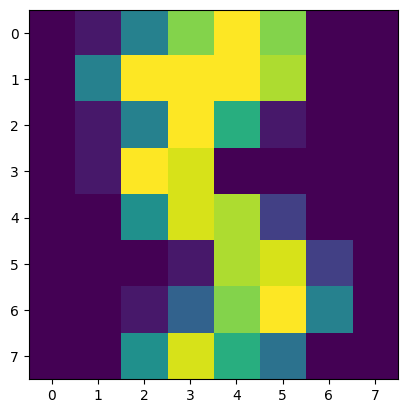

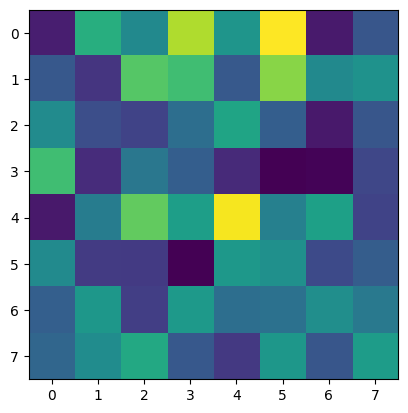

In [128]:
# test generative model itself
xtrue = X_tf[-2].numpy()
xtrue_1D = xtrue.flatten()

plt.figure()
plt.imshow(np.imag(xtrue.reshape(nx,nx)))

error, xhat_corr, yobs = reconstruct(xtrue_1D, I, G, w=1, sigma = 0, lmbda=0)
print(error)

xhat_corr = xhat_corr.reshape((nx,nx))

plt.figure()
plt.imshow(np.imag(xhat_corr))

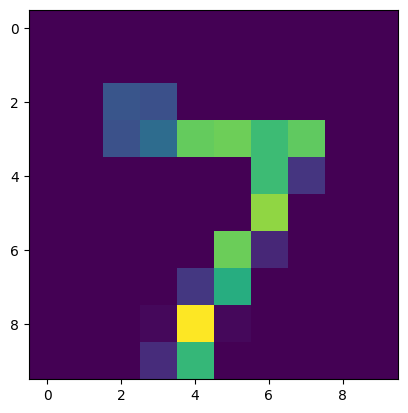

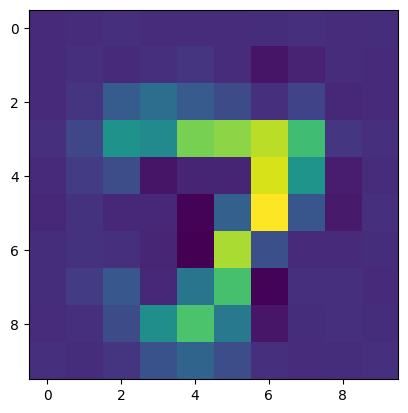

In [ ]:
# test with l2
xtrue = x_test_cx_small[0].numpy()
xtrue_1D = xtrue.flatten()

plt.figure()
plt.imshow(np.imag(xtrue))

error, xhat_corr, yobs = reconstruct(xtrue_1D, A, G, w=1, sigma=0.01, lmbda=0)

xhat_corr = xhat_corr.reshape((nx,nx))


plt.figure()
plt.imshow(np.imag(xhat_corr))

### Experiments

##### but first test if my code works for the error plots

In [ ]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 2
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k)) #here xtrue comes from the generative model

        errors_i[i,j], xhats_i[i,j,:], _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

C:\Users\Abel\AppData\Local\Temp\ipykernel_1516\1002254489.py:69: RuntimeWarning: invalid value encountered in divide
  phi = np.mean(np.angle(xtrue/xhat))
C:\Users\Abel\AppData\Local\Temp\ipykernel_1516\1002254489.py:69: RuntimeWarning: divide by zero encountered in divide
  phi = np.mean(np.angle(xtrue/xhat))


KeyboardInterrupt: 